In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.integrate import odeint

from Utilities.operators import make_tree
from Utilities.time_extractor import days_since_distruption
matplotlib.rcParams['figure.dpi'] = 150

In [28]:
folder = 'TDE'
is_tde = True
snap = '210'
m = 5
beta = 2
path = f'{folder}/{snap}'
G = 1
Mbh = 10**m
Rt = Mbh**(1/3)
Rp =  Rt / beta
R0 = 0.6 * Rp

G_SI = 6.6743e-11
Msol = 2e30 #1.98847e30 # kg
Rsol = 7e8 #6.957e8 # m
t = np.sqrt(Rsol**3 / (Msol*G_SI ))

c = 3e8 / (7e8/t)
M_bh = 10**m
Rs = 2*G*Mbh / c**2


Function for orbits

In [29]:
def to_cylindric(x,y):
    if x.any() == 0:
        if y.any()>0:
            theta_coord = np.pi/2
        elif y.any() == 0:
            theta_coord = 0
        else:
            theta_coord = 3/2 * np.pi
    else:
        theta_coord = np.arctan2(y,x)
    radius = np.sqrt(x**2+y**2)
    return radius, theta_coord

def from_cylindric(r,theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

def keplerian_orbit(theta, a, ecc = 0.999):
    p = 2 * a
    radius = p / (1 + ecc * np.cos(theta))
    return radius

def normal_plane(x_data, y_data, dim_data, theta_chosen):
    r_plane = np.sqrt(x_data**2 + y_data**2)
    if np.abs(theta_chosen) == np.pi/2:
        condition_coord = np.abs(y_data) < dim_data # horizontal line
    else:
        m = np.tan(theta_chosen)
        condition_coord = np.logical_and(np.abs(y_data - m * x_data) < dim_data, r_plane > R0)
        if theta_chosen >= 0: # if theta is in the first or second quadrant
            condition_coord = np.logical_and(condition_coord, y_data > 0)
        else:
            condition_coord = np.logical_and(condition_coord, y_data < 0)
    return condition_coord

def avg_consecutive_triplets(array, i, choose):
    if choose == 'before':
        triplet = array[i-3:i]
    else:
        triplet = array[i:i+3]
    avg = sum(triplet) / 3

    if choose == 'before':
        return avg, i-3
    else: 
        return avg, i+3

def find_width(x_mid, y_mid, dim_mid, den_mid, theta_cm):
    # find the normal plane 
    condition_coord = normal_plane(x_mid, y_mid, dim_mid, theta_cm)
    x_plane = x_mid[condition_coord]
    y_plane = y_mid[condition_coord]
    r_plane = np.sqrt(x_plane**2 + y_plane**2)
    den_plane = den_mid[condition_coord]
    # sort 
    r_plane = list(r_plane)
    r_plane_sorted = sorted(r_plane)
    indices_sort = [r_plane.index(x) for x in r_plane_sorted]
    x_plane_sorted = [x_plane[i] for i in indices_sort]
    y_plane_sorted = [y_plane[i] for i in indices_sort]
    den_plane_sorted = [den_plane[i] for i in indices_sort]
    # find the cm of the plane
    idx_cm = np.argmax(den_plane_sorted)    
    x_cm = x_plane_sorted[idx_cm]
    y_cm = y_plane_sorted[idx_cm]
    den_cm = den_plane_sorted[idx_cm]
    # walk before and after the cm till you find a density 3 times smaller
    idx_step = idx_cm
    den_tube = den_cm
    while den_tube > den_cm/3:
        idx_step -= 1
        den_tube, idx_before = avg_consecutive_triplets(den_plane_sorted, idx_step, choose = 'before')
    idx_before = int(idx_before)
    x_low = x_plane_sorted[idx_before]
    y_low = y_plane_sorted[idx_before]
    den_low = den_plane_sorted[idx_before]

    idx_step = idx_cm
    den_tube = den_cm
    while den_tube > den_cm/3:
        idx_step += 1
        den_tube, idx_after = avg_consecutive_triplets(den_plane_sorted, idx_step, choose = 'after')
    idx_after = int(idx_after)
    x_high = x_plane_sorted[idx_after]
    y_high = y_plane_sorted[idx_after]
    den_high = den_plane_sorted[idx_after]
    
    return x_cm, y_cm, den_cm, x_low, y_low, den_low, x_high, y_high, den_high

def find_width_stream(x_mid, y_mid, dim_mid, den_mid, theta_arr):
    cm = np.zeros((3,len(theta_arr)))
    upper_tube = np.zeros((3,len(theta_arr)))
    lower_tube = np.zeros((3,len(theta_arr)))
    for i,theta in enumerate(theta_arr):
        x_cm, y_cm, den_cm, x_low, y_low, den_low, x_high, y_high, den_high = find_width(x_mid, y_mid, dim_mid, den_mid, theta)
        cm[0][i], cm[1][i], cm[2][i] = x_cm, y_cm, den_cm
        lower_tube[0][i], lower_tube[1][i], lower_tube[2][i] = x_low, y_low, den_low
        upper_tube[0][i], upper_tube[1][i], upper_tube[2][i] = x_high, y_high, den_high
    
    return cm, upper_tube, lower_tube


In [30]:
def solvr(Y, theta):
    L = 1
    y0 = Y[1]
    y1 =  -Y[0] + G * Mbh / ((1 - Rs**Y[0]) * L**2)
    return [y0, y1]

In [31]:
a_theta = np.arange(-np.pi/2, np.pi/2, 0.01)
asol = odeint(solvr, [0, 1e4], a_theta)
print(asol)

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
[[0.00000000e+000 1.00000000e+004]
 [            nan             nan]
 [            nan             nan]
 [2.13180624e-314 2.73476822e-314]
 [2.73496999e-314 2.13180624e-314]
 [2.73476828e-314 2.73497024e-314]
 [2.13180624e-314 2.73476891e-314]
 [2.73475974e-314 2.13236152e-314]
 [2.73497429e-314 2.13238504e-314]
 [2.73475978e-314 2.73497381e-314]
 [2.73475981e-314 2.73497648e-314]
 [2.73497667e-314 2.73497671e-314]
 [2.73497675e-314 2.73497679e-314]
 [2.73497683e-314 2.73497687e-314]
 [2.73497691e-314 2.73497695e-314]
 [2.73497699e-314 2.73497703e-314]
 [2.13170467e-314 2.13180624e-314]
 [2.13180624e-314 2.73476834e-314]
 [2.73476831e-314 2.13236152e-314]
 [2.73497644e-314 2.13236152e-314]
 [2.73497707e-314 2.13238504e-314]
 [2.73476825e-314 2.73497711e-314]
 [2.73476844e-314 2.13238498e-314]
 [2.13236152e-314 2.73476

/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_11319/645924924.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  y1 =  -Y[0] + G * Mbh / ((1 - Rs**Y[0]) * L**2)


In [32]:
# cfr tidal disruption 
xRt = np.linspace(-Rt, Rt, 100)
yRt = np.linspace(-Rt, Rt, 100)
xcfr, ycfr = np.meshgrid(xRt,yRt)
cfr = xcfr**2 + ycfr**2 - Rt**2

# cfr smoothing lenght
xR0 = np.linspace(-R0, R0, 100)
yR0 = np.linspace(-R0, R0, 100)
xcfr0, ycfr0 = np.meshgrid(xR0,yR0)
cfr0 = xcfr0**2 + ycfr0**2 - R0**2

# Parabolic orbit
theta_arr = np.arange(0, 2*np.pi, 0.01)
orbit = keplerian_orbit(theta_arr, a = Rp)
x_orbit, y_orbit = from_cylindric(orbit, theta_arr) 

Load data

In [33]:
# sim_tree, X, Y, Z, Vol, VX, VY, VZ, Den, Press, Temp, IE, Diss, Entropy = make_tree(path, snap, is_tde, energy = True)
sim_tree, X, Y, Z, Vol, VX, VY, VZ, Den, Press, Temp = make_tree(path, snap, is_tde, energy = False)

Star = np.load(f'{path}/Star_{snap}.npy')
# div = np.load(f'{folder}/{snap}/DivV_{snap}.npy')
# shockzone = np.loadtxt(f'data/{snap}/shockzone_{snap}.txt')
# shocksurface = np.loadtxt(f'data/{snap}/shocksurface_{snap}.txt')

R = np.sqrt(X**2 + Y**2 + Z**2)
V = np.sqrt(VX**2 + VY**2 + VZ**2)
dim_cell = Vol**(1/3) # according to Elad
time, tfb = days_since_distruption(f'{path}/snap_{snap}.h5', m=m, choose = 'tfb')

# Shock zone
# idx_zone = shockzone[0]
# idx_zone = np.array([int(i) for i in idx_zone])
# x_zone = X[idx_zone]
# y_zone = Y[idx_zone]
# z_zone = Z[idx_zone]
# Vx_zone = VX[idx_zone]
# Vy_zone = VY[idx_zone]
# Vz_zone = VZ[idx_zone]
# Diss_zone = Diss[idx_zone]
# dim_cell_zone = dim_cell[idx_zone]
# div_zone = div[idx_zone]

# Shock surface
# idx_surf = shocksurface[0]
# idx_surf = np.array([int(i) for i in idx_surf])
# x_surf = x_zone[idx_surf]
# y_surf = y_zone[idx_surf]
# z_surf = z_zone[idx_surf]
# Vx_surf = Vx_zone[idx_surf]
# Vy_surf = Vy_zone[idx_surf]
# dim_cell_surf = dim_cell_zone[idx_surf]
# div_surf = div_zone[idx_surf]


days after disruption: 3.456952163743516, t_fall: 12.649110640673518


In [34]:
len(X[np.logical_and(R<R0, np.abs(Z)<0.3)])

1626

Midplane 

In [35]:
# take wanted data
midplane = np.abs(Z) < 0.3#dim_cell
# midplane_zone = np.abs(z_zone)< dim_cell_zone
# midplane_surf = np.abs(z_surf)<dim_cell_surf

X_cross = X[midplane]
Y_cross = Y[midplane]
VX_cross = VX[midplane]
VY_cross = VY[midplane]
Vol_cross = Vol[midplane]
dim_cross = dim_cell[midplane]
Temp_cross = Temp[midplane]
Den_cross = Den[midplane]
# Diss_cross = Diss[midplane]
# Entropy_cross = Entropy[midplane]
Star_cross = Star[midplane]
# div_cross = div[midplane]

# zone_cross_x = x_zone[midplane_zone]
# zone_cross_y = y_zone[midplane_zone]

# x_cross_surf = x_surf[midplane_surf]
# y_cross_surf = y_surf[midplane_surf]
# Vx_cross_surf = Vx_surf[midplane_surf]
# Vy_cross_surf = Vy_surf[midplane_surf]
# div_cross_surf = div_surf[midplane_surf]

Text(0.5, 1.0, 'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = 0.273')

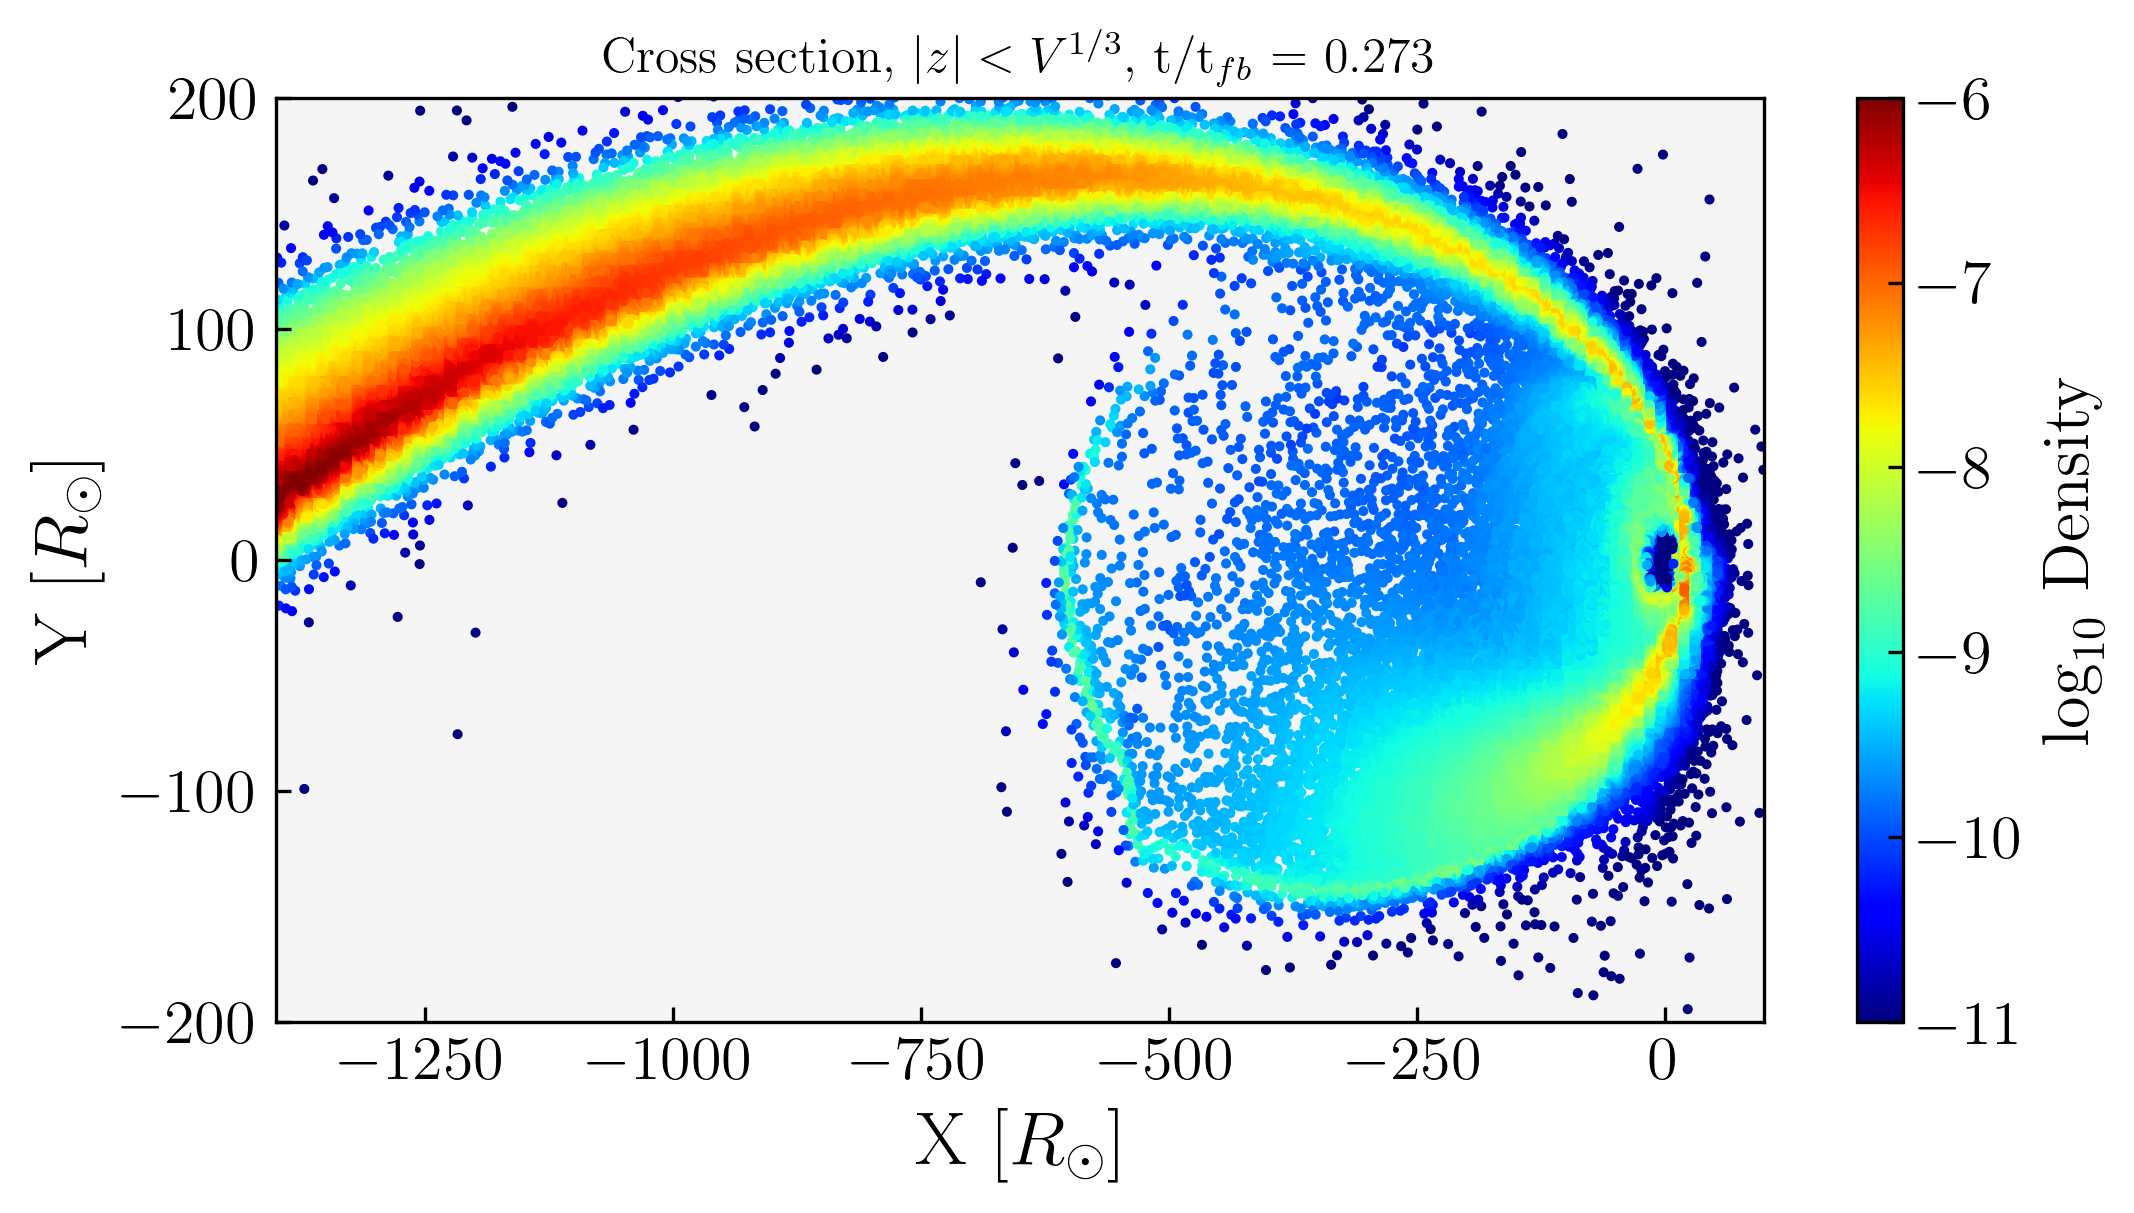

In [36]:
# Keplerian orbit
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots(1,1, figsize = (8,4))
img = ax.scatter(X_cross, Y_cross, c = np.log10(Den_cross), s = 2, cmap = 'jet', vmin = -11, vmax = -6)
cbar = plt.colorbar(img)
cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
ax.set_xlim(-1400,100)
ax.set_ylim(-200,200)
ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax.set_ylabel(r'Y [$R_\odot$]', fontsize = 18)
plt.title(r'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = ' + str(np.round(tfb,3)))


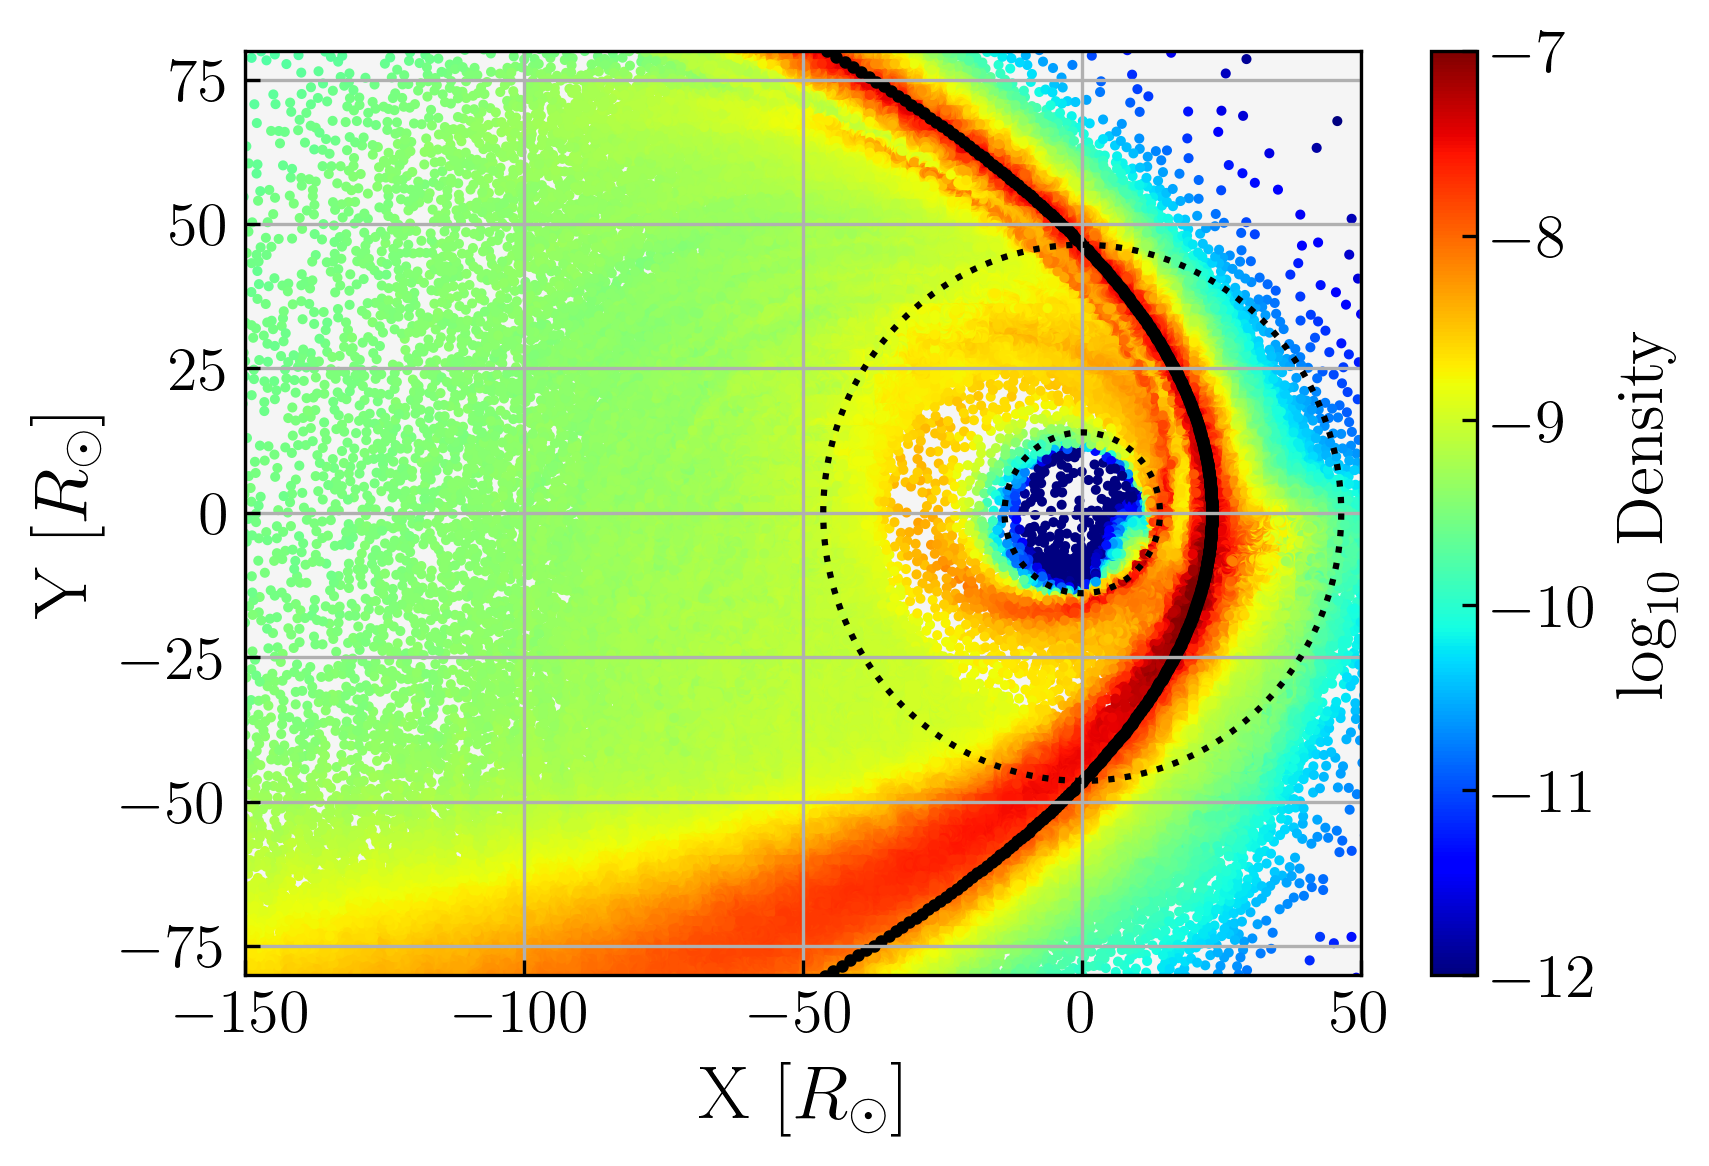

In [40]:
# Keplerian orbit
fig, ax = plt.subplots(1,1, figsize = (6,4))
img = ax.scatter(X_cross, Y_cross, c = np.log10(Den_cross), s = 2, cmap = 'jet', vmin = -12, vmax = -7)
#ax.quiver(X_cross[::50], Y_cross[::50], VX_cross[::50], VY_cross[::50], color = 'k', angles='xy', scale_units='xy', width = 1e-3)#, scale = 40)
cbar = plt.colorbar(img)
cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
ax.contour(xcfr, ycfr, cfr, [0], linestyles = 'dotted', colors = 'k')
ax.contour(xcfr0, ycfr0, cfr0, [0], linestyles = 'dotted', colors = 'k')
ax.scatter(x_orbit, y_orbit, color = 'k', s = 4)
ax.set_xlim(-150,50)
ax.set_ylim(-80,80)
ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax.set_ylabel(r'Y [$R_\odot$]', fontsize = 18)
plt.grid()
# plt.title(r'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = ' + str(np.round(tfb,3)))

In [38]:
theta_lim = 3/4*np.pi
theta_arr = np.concatenate((np.arange(theta_lim, 0, -0.1), np.arange(0, -theta_lim, -0.1))) #0.01 as the epsilon in the find_sz plane function

In [39]:
cm, upper_tube, lower_tube  = find_width_stream(X_cross, Y_cross, dim_cross, Den_cross, theta_arr)

IndexError: list index out of range

Text(0, 0.5, 'Y [$R_\\odot$]')

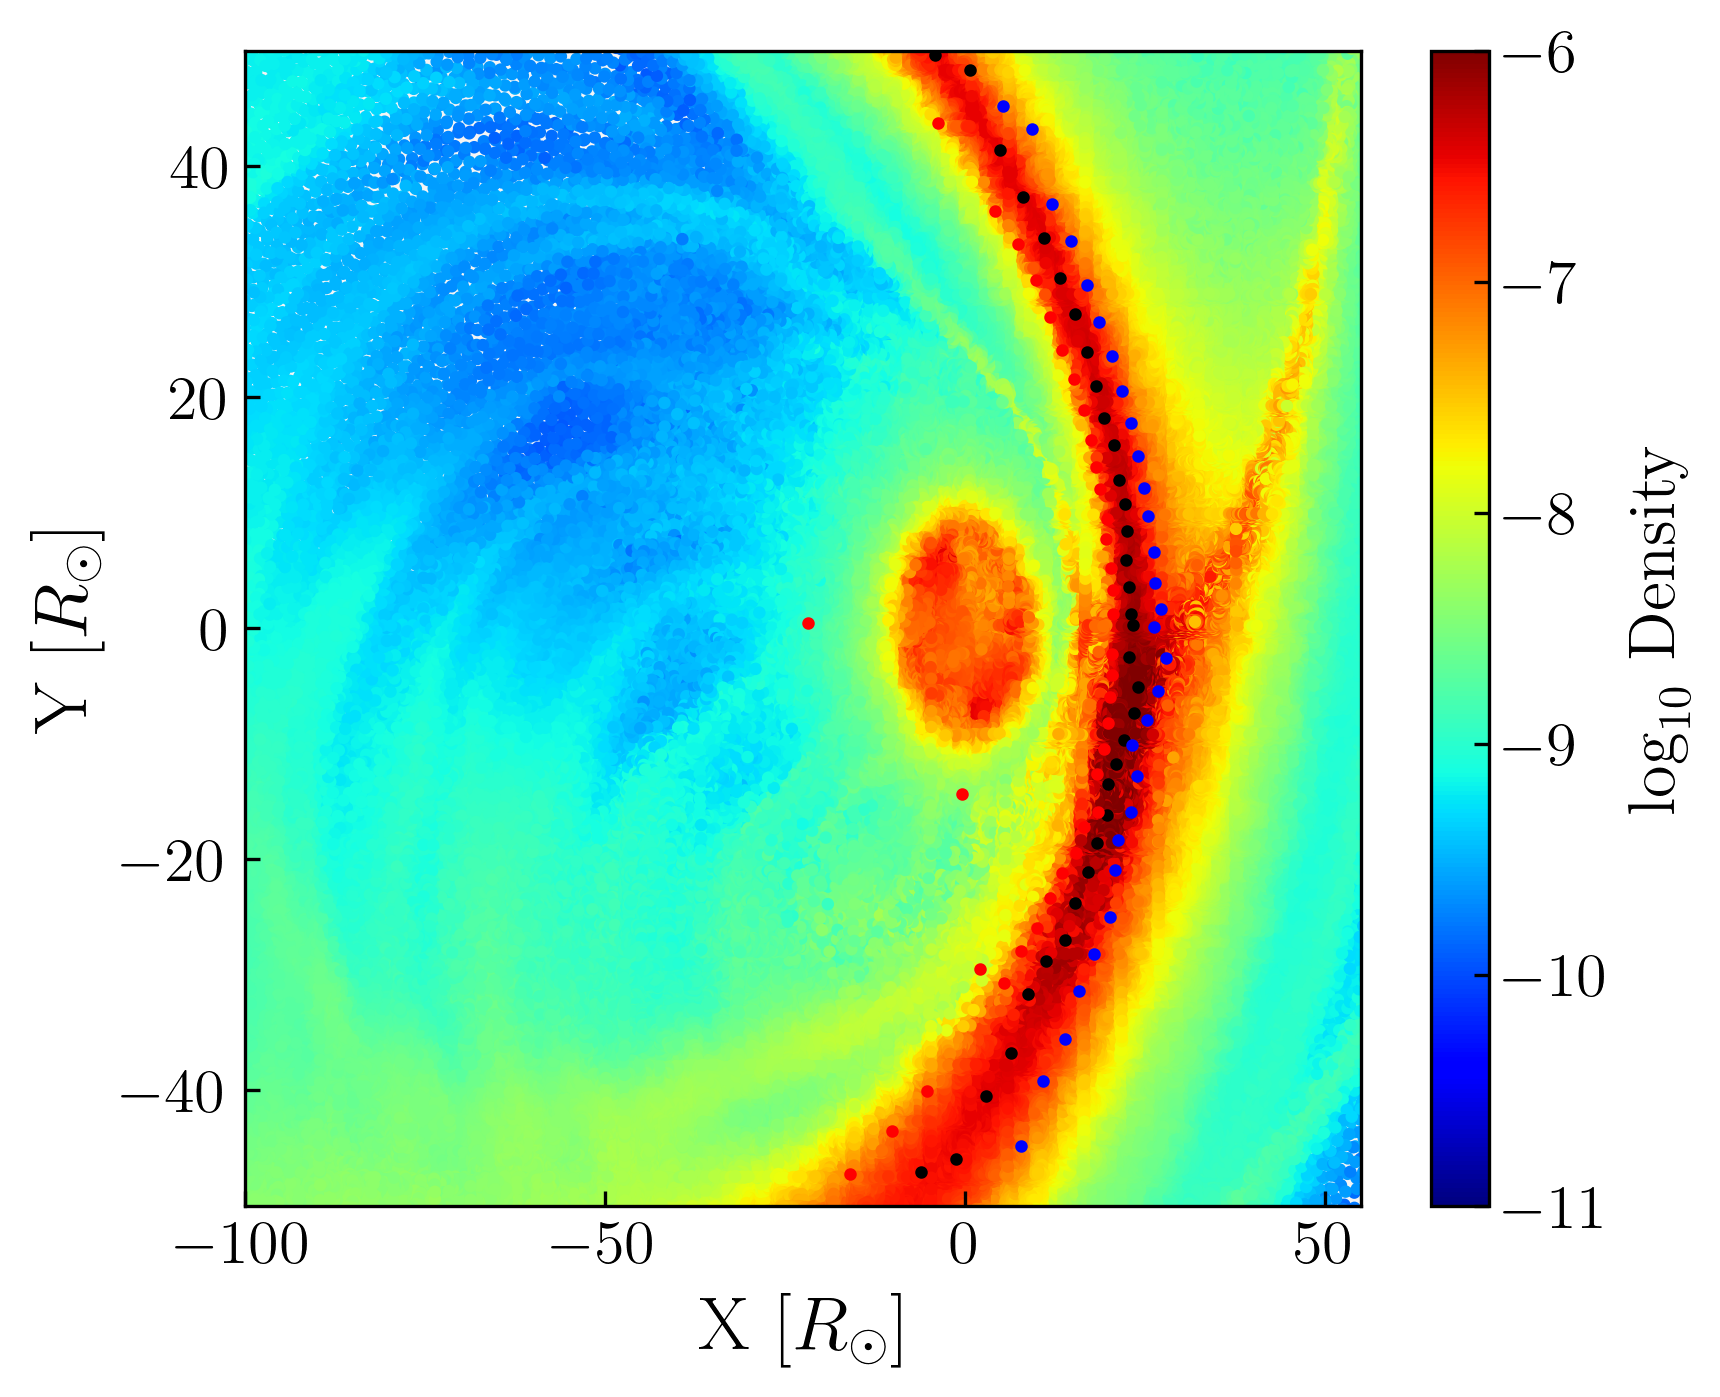

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (6,5))
img = ax.scatter(X_cross, Y_cross, c = np.log10(Den_cross), s = 4, cmap = 'jet', vmin = -11, vmax = -6)
cbar = plt.colorbar(img)
cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
ax.scatter(cm[0], cm[1], s = 4, c = 'k')
ax.scatter(upper_tube[0], upper_tube[1], s = 4, c = 'b')
ax.scatter(lower_tube[0], lower_tube[1], s = 4, c = 'r')
ax.set_xlim(-100,55)
ax.set_ylim(-50,50)
ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax.set_ylabel(r'Y [$R_\odot$]', fontsize = 18)

NameError: name 'x_cross_surf' is not defined

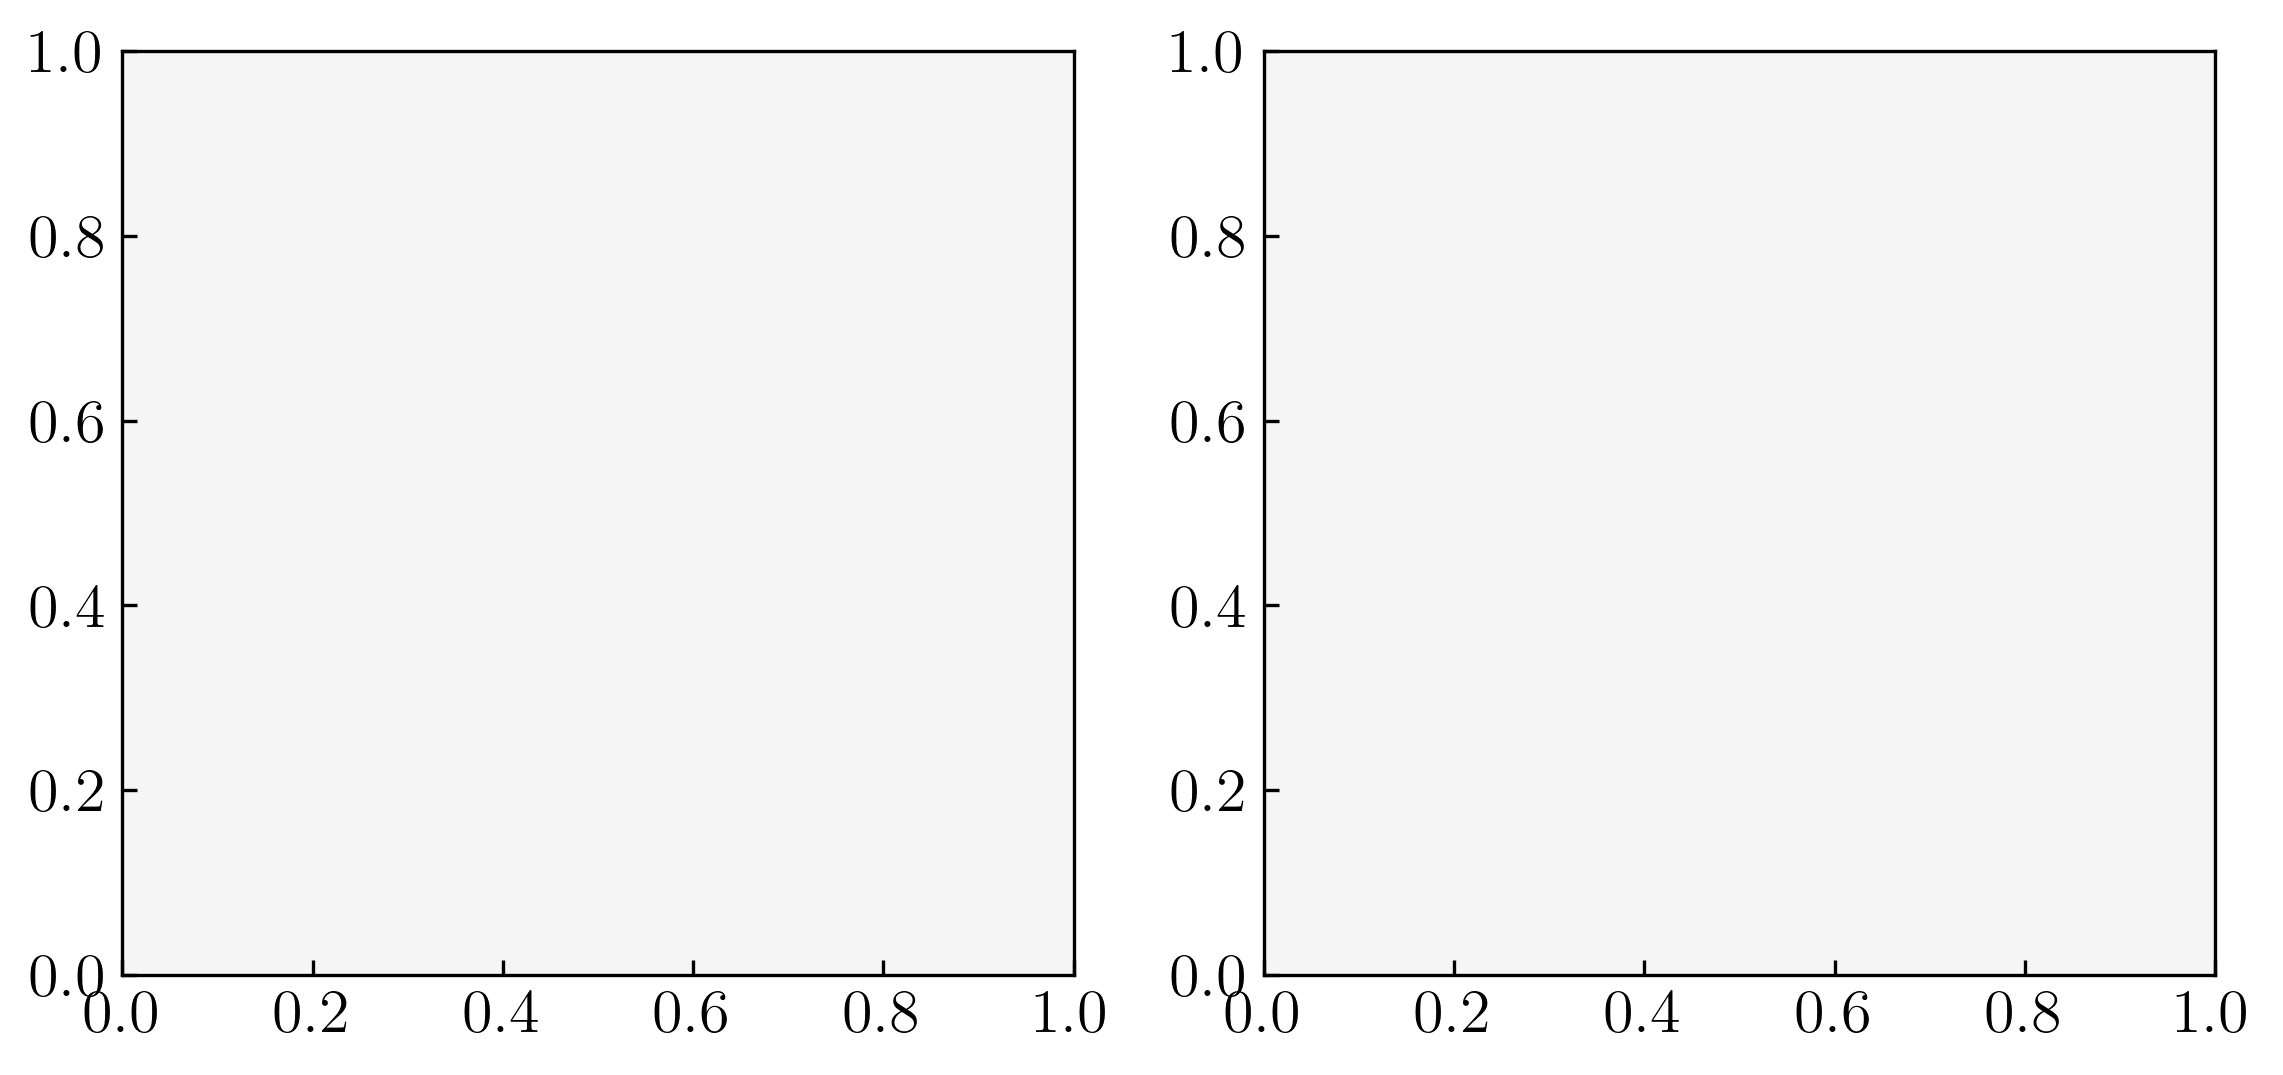

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (9,4))
# ax.plot(zone_cross_x, zone_cross_y, 'ks', markerfacecolor='none', ms = 5, markeredgecolor='k', label = 'shock zone')
ax[0].plot(x_cross_surf, y_cross_surf, 'ks', markerfacecolor='none', ms = 2, markeredgecolor='k', alpha = 0.5, label = 'shock front')
img = ax[0].scatter(X_cross, Y_cross, c = np.log10(Den_cross), s = 4, cmap = 'viridis', vmin = -12, vmax = -7)
cbar = plt.colorbar(img)#, format='%.0e')
cbar.set_label(r'$\log_{10}$ Density [$M_\odot/R_\odot^3$]', fontsize = 12)
ax[0].set_xlim(3,28)
ax[0].set_ylim(-15,23)
ax[0].set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax[0].set_ylabel(r'Y [$R_\odot$]', fontsize = 18)
ax[0].legend(loc = 'upper right')
plt.grid()


img1 = ax[1].scatter(X_cross, Y_cross, c = div_cross, s = 5, cmap = 'cividis', vmin = -50, vmax = 10)
cbar1 = plt.colorbar(img1)#, format='%.0e')
cbar1.set_label(r'$\nabla v [1/\tilde{t}]$', fontsize = 12)
ax[1].plot(x_cross_surf, y_cross_surf, 'ks', markerfacecolor='none', ms = 2, markeredgecolor='k', alpha = 0.5, label = 'shock surface')
ax[1].set_xlim(3,28)
ax[1].set_ylim(-15,23)
ax[1].set_xlabel(r'X [$R_\odot$]', fontsize = 18)
plt.grid()


plt.tight_layout()


Text(0, 0.5, 'Y [$R_\\odot$]')

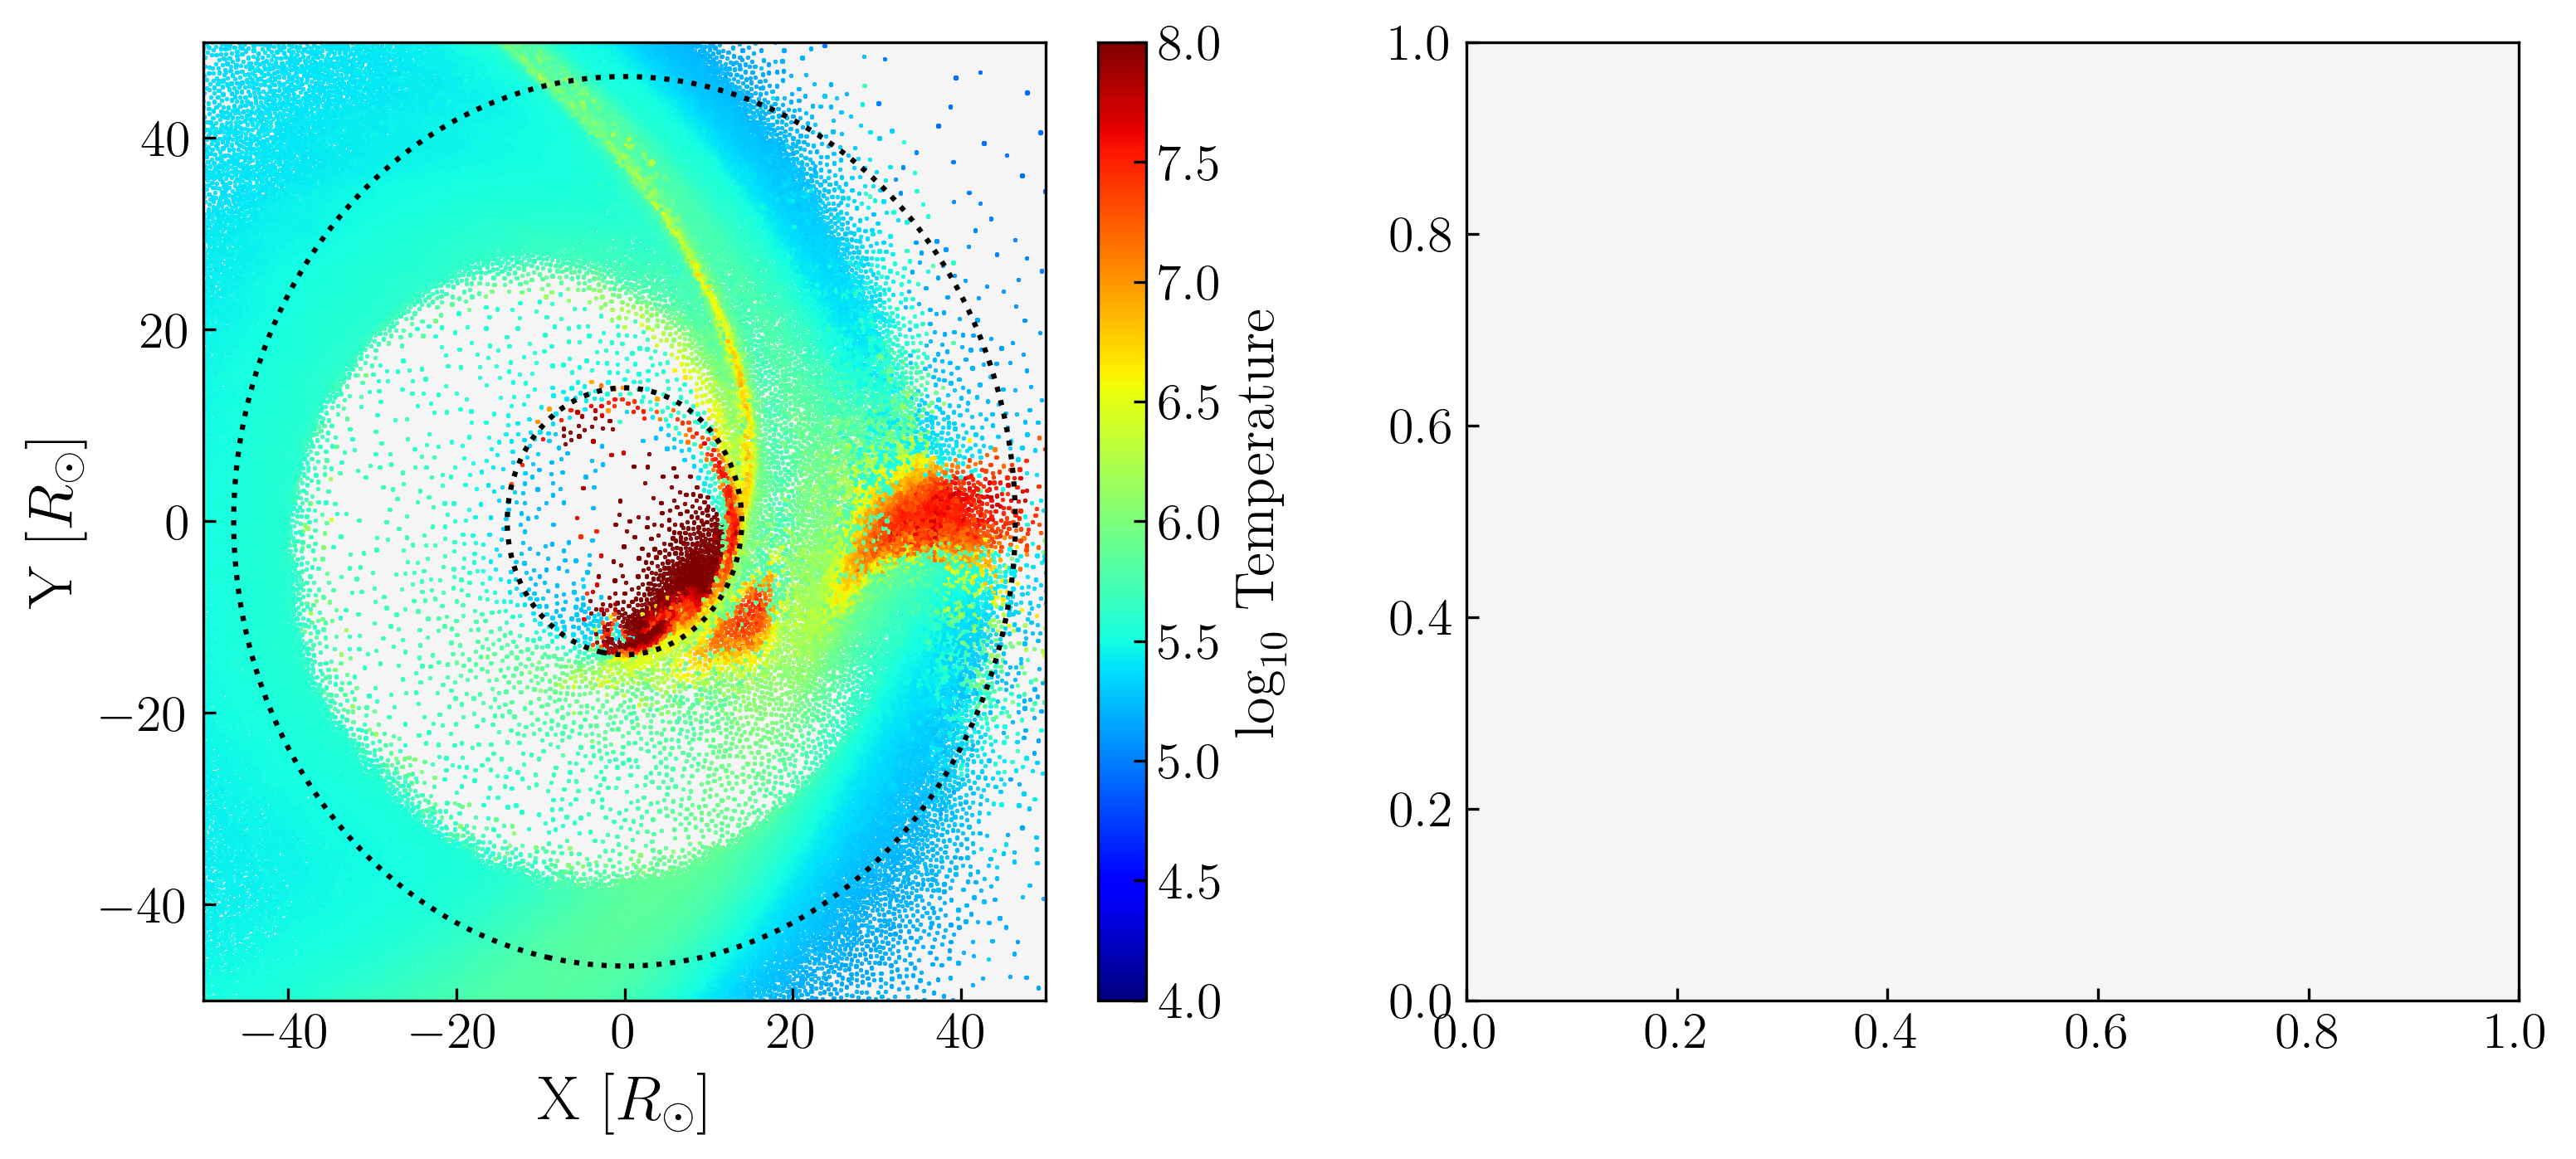

In [41]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
img = ax[0].scatter(X_cross, Y_cross, c = np.log10(Temp_cross), marker= 's', s = 0.1, cmap = 'jet', vmin = 4, vmax = 8)
ax[0].contour(xcfr, ycfr, cfr, [0], linestyles = 'dotted', colors = 'k')
ax[0].contour(xcfr0, ycfr0, cfr0, [0], linestyles = 'dotted', colors = 'k')
cbar = plt.colorbar(img)#, format='%.0e')
cbar.set_label(r'$\log_{10}$ Temperature', fontsize = 16)
ax[0].set_xlim(-50,50)
ax[0].set_ylim(-50,50)
ax[0].set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax[0].set_ylabel(r'Y [$R_\odot$]', fontsize = 18)

# img1 = ax[1].scatter(X_cross, Y_cross, c = Entropy_cross, s = 4, cmap = 'jet', vmin = 1.5e-6, vmax = 4e-6)
# ax[1].quiver(X_cross[::40], Y_cross[::40], VX_cross[::40], VY_cross[::40], color = 'k', angles='xy', scale_units='xy', width = 1.5e-3)#, scale = 40)
# cbar1 = plt.colorbar(img1)#, format='%.0e')
# cbar1.set_label(r'Entropy', fontsize = 16)
# ax[1].set_xlim(-20,20)
# ax[1].set_ylim(-20,20)
# ax[1].set_xlabel(r'X [$R_\odot$]', fontsize = 18)
# plt.tight_layout()
# plt.suptitle(r'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = ' + str(np.round(tfb,3)))

X-Z plane

In [ ]:
ychosen = Rp
crossXZ = np.abs(Y-ychosen) < dim_cell

X_crossXZ = X[crossXZ]
Z_crossXZ = Z[crossXZ]
VX_crossXZ = VX[crossXZ]
VZ_crossXZ = VZ[crossXZ]
Temp_crossXZ = Temp[crossXZ]
Den_crossXZ = Den[crossXZ]

Text(0.5, 1.0, 'Cross section, Y = $R_{p}$')

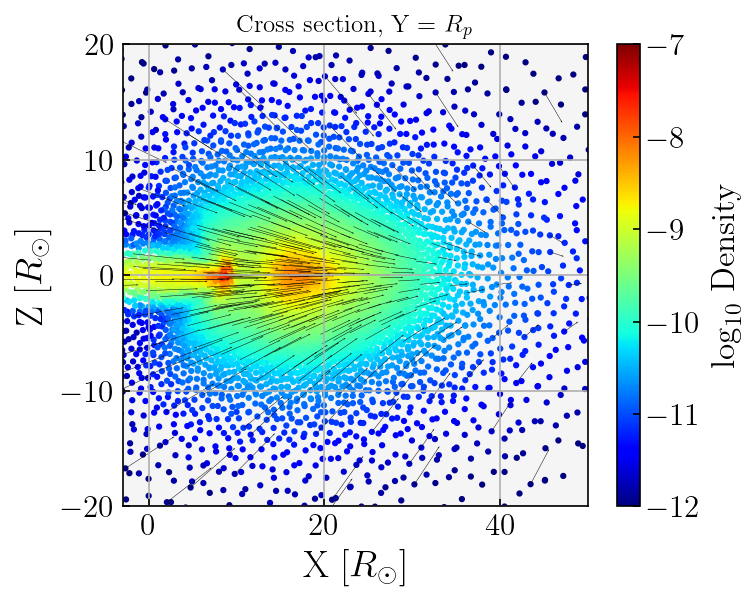

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (5,4))
img = ax.scatter(X_crossXZ, Z_crossXZ, c = np.log10(Den_crossXZ),  s = 4, cmap = 'jet', vmin = -12, vmax = -7)
ax.quiver(X_crossXZ[::20], Z_crossXZ[::20], VX_crossXZ[::20], VZ_crossXZ[::20], color = 'k', angles='xy', scale_units='xy', width = 1e-3, scale = 10)
cbar = plt.colorbar(img)
cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
ax.set_xlim(-3,50)
ax.set_ylim(-20,20)
ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax.set_ylabel(r'Z [$R_\odot$]', fontsize = 18)
plt.grid()
plt.title(r'Cross section, Y = $R_{p}$')

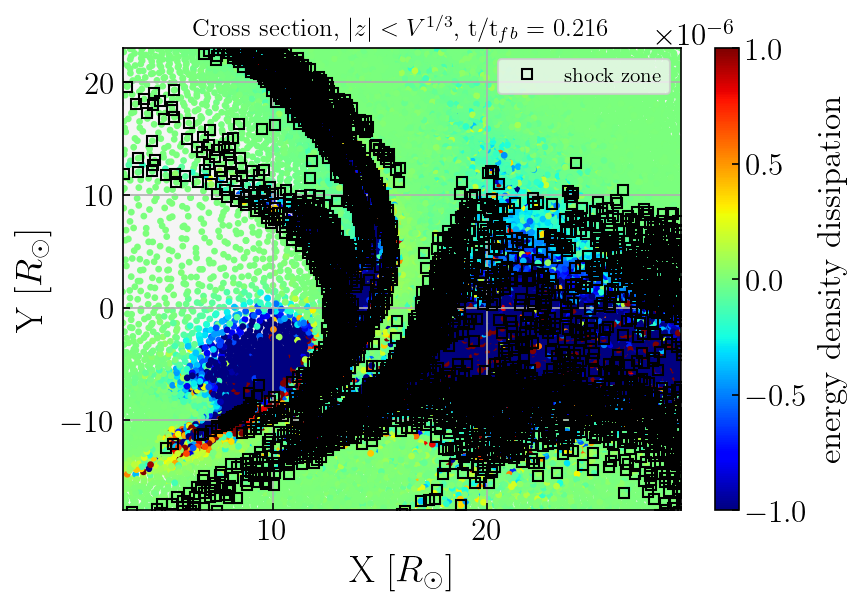

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (6,4))
img = ax.scatter(X_cross, Y_cross, c = Diss_cross/Vol_cross, s = 5, cmap = 'jet', vmin = -1e-6, vmax = 1e-6)
cbar = plt.colorbar(img)#, format='%.0e')
cbar.set_label('energy density dissipation', fontsize = 16)
ax.plot(zone_cross_x, zone_cross_y, 'ks', markerfacecolor='none', ms = 5, markeredgecolor='k', label = 'shock zone')
#ax.plot(x_cross_surf, y_cross_surf, 'ks', markerfacecolor='none', ms = 5, markeredgecolor='k', label = 'shock surface')
ax.set_xlim(3,29)
ax.set_ylim(-18,23)
ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax.set_ylabel(r'Y [$R_\odot$]', fontsize = 18)
plt.grid()
plt.title(r'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = ' + str(np.round(tfb,3)))
plt.legend(loc = 'upper right')
#plt.savefig('Figs/EnDisszone.png')

Stone13

In [ ]:
def Nick_fall(z0, theta, b = beta):
    zE = 1/b * 2*np.sin(theta) / (1+np.cos(theta))
    zF = 1/b * 2*np.cos(theta) / (1+np.cos(theta))
    E = -z0 * np.sqrt(b-1)
    F = z0
    return E*zE + F*zF 

In [ ]:
z_arr = np.arange(-1, 1, 0.2)
free_fall = []
for i,z0 in enumerate(z_arr):
    z = Nick_fall(z0, theta_arr)
    free_fall.append(z)

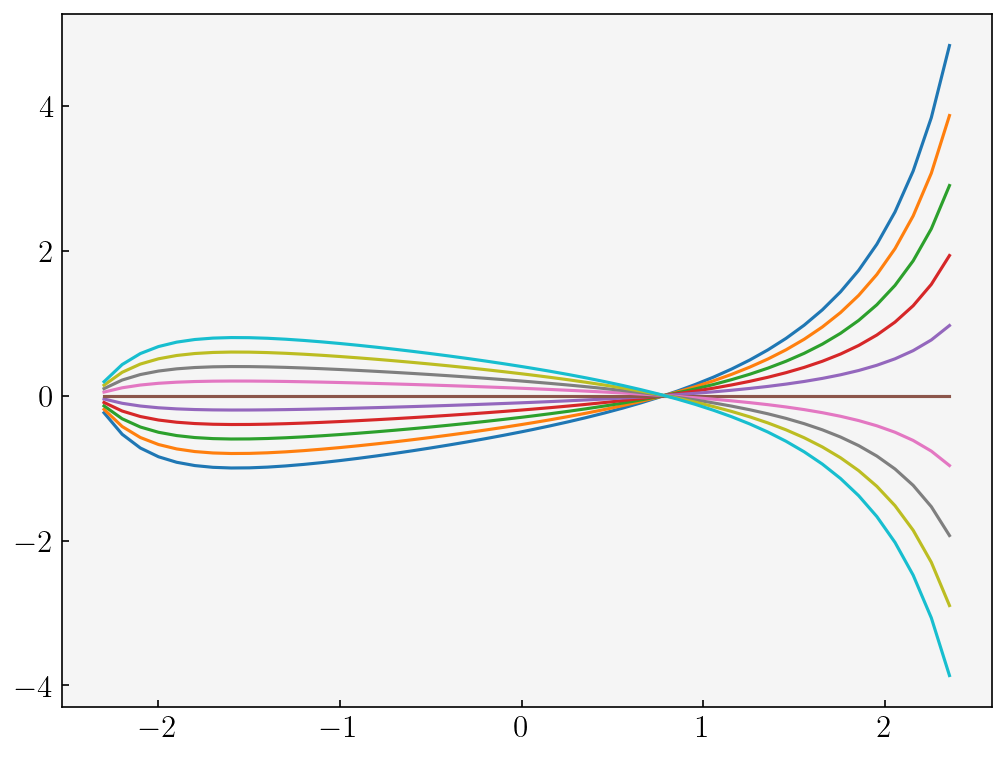

In [ ]:
for i in range(len(z_arr)):
    plt.plot(theta_arr, free_fall[i])
